In [1]:
from plotting import *
from scipy.optimize import curve_fit

In [10]:
ave_MEM_0 = np.loadtxt('output/base2w_MEM_cor_0_mom1__ave.txt')
err_MEM_0 = np.loadtxt('output/base2w_MEM_cor_0_mom1__sem.txt')
dt_MEM_0 = np.loadtxt('output/base2w_MEM_cor_0_mom1__dt.txt')

In [11]:
ave_MEM_1 = np.loadtxt('output/base2w_MEM_cor_1_mom1__ave.txt')
err_MEM_1 = np.loadtxt('output/base2w_MEM_cor_1_mom1__sem.txt')
dt_MEM_1 = np.loadtxt('output/base2w_MEM_cor_1_mom1__dt.txt')

In [12]:
ave_MEM_5 = np.loadtxt('output/base2w_MEM_cor_5_mom1__ave.txt')
err_MEM_5 = np.loadtxt('output/base2w_MEM_cor_5_mom1__sem.txt')
dt_MEM_5 = np.loadtxt('output/base2w_MEM_cor_5_mom1__dt.txt')

In [13]:
ave_EM = np.loadtxt('output/base2w_EM_mom1__ave.txt')
err_EM = np.loadtxt('output/base2w_EM_mom1__sem.txt')
dt_EM = np.loadtxt('output/base2w_EM_mom1__dt.txt')

In [5]:
ave_EM_s = np.loadtxt('output/base2s_EM_ave.txt')
err_EM_s = np.loadtxt('output/base2s_EM_sem.txt')
dt_EM_s = np.loadtxt('output/base2s_EM_dt.txt')

In [14]:
vcomp =0

In [15]:
help(formatAndSave)

Help on function formatAndSave in module plotting:

formatAndSave(fig, ax, lines, xlabel, ylabel, legends=None, title=None, fontsize=14, filename=None)
    formats the current figure, and save to file if filename is provided.



In [18]:
def diffAnderr(ave, err):
    high = ave[:-1, :]
    low = ave[1:, :]
    diff = np.abs((high - low)/low) 
    err_low = err[1:, :] * (high / low**2) #the error on the denominator
    err_high = err[:-1, :] / low
    err = np.sqrt(err_low**2 + err_high**2)
    return diff, err

def power(x, c):
    return c * (x**1)

Text(0, 0.5, 'Relative error in $<v_x^2>$')

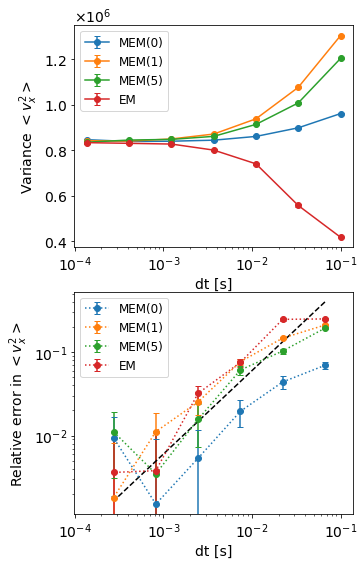

In [22]:
fig= plt.figure()
updateGlobal(14)
fig.set_size_inches(5, 9)
# plt.tight_layout()

ax1 = fig.add_subplot(211)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits=(0, 0), useMathText=True)
ax2 = fig.add_subplot(212, sharex = ax1)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits=(0, 0), useMathText=True)

# fig, [ax1, ax2] = plt.subplots(2, 1)


for dt, ave, err, lab, truncate, c in zip([dt_MEM_0, dt_MEM_1, dt_MEM_5, dt_EM], 
                         [ave_MEM_0, ave_MEM_1, ave_MEM_5, ave_EM], 
                         [err_MEM_0, err_MEM_1, err_MEM_5, err_EM], 
                         ['MEM(0)', 'MEM(1)', 'MEM(5)', 'EM'], 
                                       [-3, -3, -2, -3],
                                      ['C0', 'C1', 'C2', 'C3']):
# for dt, ave, err, lab, truncate, c in zip([dt_MEM_0, dt_MEM_5, dt_EM], 
#                          [ave_MEM_0, ave_MEM_5, ave_EM], 
#                          [err_MEM_0, err_MEM_5, err_EM], 
#                          ['MEM(0)', 'MEM(5)', 'EM'], 
#                                        [-2, -1, -2],
#                                       ['C0', 'C1', 'C2']):
    ax1.errorbar(dt[:truncate], ave[:truncate, vcomp], err[:truncate, vcomp], 
                 color = c, marker = 'o', capsize = 3,label = lab)
    diff_ave, diff_err = diffAnderr(ave, err)
#     ax2.plot(dt_EM[:-1], diff_ave[:, vcomp])
    t_mid = 0.5 * (dt[:-1] + dt[1:])
    
    # A power fit
    popt, pcov = curve_fit(power, t_mid[:truncate], diff_ave[:truncate, vcomp], 
                           sigma=diff_err[:truncate, vcomp], absolute_sigma=True,
                          )
    perr = np.sqrt(np.diag(pcov))
#     print(popt[1], perr[1])
    # plot fit and data
#     ax2.plot(t_mid[:truncate], power(t_mid[:truncate], *popt), '-', color = c)
#     lab = lab+'$alpha={}$'.format(popt[1])
    ebar = ax2.errorbar(t_mid[:truncate], diff_ave[:truncate, vcomp], 
                 diff_err[:truncate, vcomp], 
                 color = c, fmt = 'o:', capsize = 3, label = lab)
             
ax2.plot(t_mid[:truncate], 6*t_mid[:truncate], 'k--')    
for ax in [ax1, ax2]:    
    ax.set_xscale('log')
    ax.set_xlabel('dt [s]')
    ax.legend()

ax1.set_ylabel('Variance $<v_x^2>$')

ax2.set_yscale('log')
ax2.set_ylabel('Relative error in $<v_x^2>$')
# fig.savefig('./figures/weakConv_x.pdf', bbox_inches = "tight")

In [145]:
line

(<matplotlib.lines.Line2D at 0x1a2dc37590>,
 (<matplotlib.lines.Line2D at 0x1a2dc358d0>,
  <matplotlib.lines.Line2D at 0x1a2dc35f50>),
 (<matplotlib.collections.LineCollection at 0x1a2dc35ad0>,))

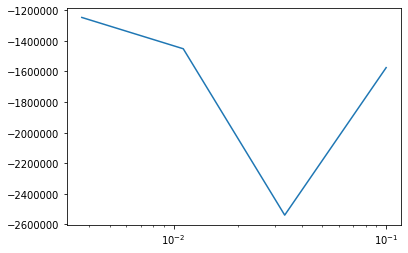

In [7]:
plt.errorbar(dt_EM_s, ave_EM_s[:, vcomp], err_EM_s[:, vcomp])
plt.xscale('log')
# plt.yscale('log')

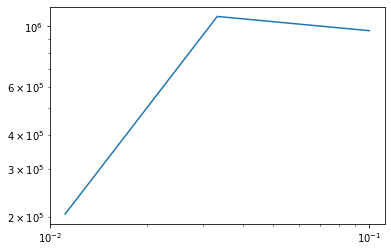

In [9]:
diff_ave = np.abs(np.diff(ave_EM_s, axis = 0))
plt.errorbar(dt_EM_s[:-1], diff_ave[:, vcomp], err_EM_s[:-1, vcomp])
# plt.plot(dt[:-1], diff_ave[:, 0])
plt.yscale('log')
plt.xscale('log')